#Formatando os nomes corretamente

In [ ]:
import os
import re
import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessamento de dados
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Algoritmos de classificação
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Classificador LightGBM
from lightgbm import LGBMClassifier

# Métricas de avaliação
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Instalar e importar TabNet
!pip install pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
IMAGES_FOLDER = '/content/drive/MyDrive/breast-images'

IMAGE_PATHS = sorted([os.path.join(IMAGES_FOLDER, file) for file in os.listdir(IMAGES_FOLDER)])

IMAGE_NAMES = [os.path.basename(path) for path in IMAGE_PATHS]

for name in IMAGE_NAMES[:5]:
        print(name)

0_Calc-Test_P_00038_LEFT_CC_1_roi.png
0_Calc-Test_P_00038_LEFT_MLO_1_roi.png
0_Calc-Test_P_00100_RIGHT_CC_1_roi.png
0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png
0_Calc-Test_P_00141_LEFT_CC_1_roi.png


In [ ]:
df_image_names = pd.DataFrame(IMAGE_NAMES, columns=['Image Names'])

df_image_names.head(5)

Image Names
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png

In [ ]:
print(f'Quantidade de linhas: {df_image_names.shape[0]}')

Quantidade de linhas: 2338


In [ ]:
FEATURES_PATH = ['/content/drive/MyDrive/features-radiomics/base_nome.csv',
                 '/content/drive/MyDrive/features-radiomics/all_data_radiomics_new_base_16bits.csv',
                 ]

df_features_names = pd.read_csv(FEATURES_PATH[0])

df_features_names.head(5)

name
0    Calc-Test_P_00038_LEFT_CC_1_1-1.dcm
1   Calc-Test_P_00038_LEFT_MLO_1_1-1.dcm
2   Calc-Test_P_00100_RIGHT_CC_1_1-1.dcm
3  Calc-Test_P_00100_RIGHT_MLO_1_1-1.dcm
4    Calc-Test_P_00141_LEFT_CC_1_1-1.dcm

In [ ]:
print(f'Quantidade de linhas: {df_features_names.shape[0]}')

Quantidade de linhas: 2587


In [ ]:
df = pd.read_csv(FEATURES_PATH[1])

df['class'].head(5)

0    BENIGN
1    BENIGN
2    BENIGN
3    BENIGN
4    BENIGN
Name: class, dtype: object

In [ ]:
def transformar_nome_imagem(nome_arquivo, classe):
    prefixos = {
        'BENIGN': '0_',
        'BENIGN_WITHOUT_CALLBACK': '1_',
        'MALIGNANT': '2_'
    }

    prefixo = prefixos.get(classe, '')
    novo_nome = prefixo + nome_arquivo
    novo_nome = re.sub(r'_\d+-\d+\.dcm$|\.dcm$', '', novo_nome)
    novo_nome += '_roi.png'

    return novo_nome

df_features_names['Transformed Image Names'] = [
    transformar_nome_imagem(nome, classe)
    for nome, classe in zip(df_features_names['name'], df['class'])
]

df_features_names.head(5)

name  \
0    Calc-Test_P_00038_LEFT_CC_1_1-1.dcm   
1   Calc-Test_P_00038_LEFT_MLO_1_1-1.dcm   
2   Calc-Test_P_00100_RIGHT_CC_1_1-1.dcm   
3  Calc-Test_P_00100_RIGHT_MLO_1_1-1.dcm   
4    Calc-Test_P_00141_LEFT_CC_1_1-1.dcm   

                   Transformed Image Names  
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png  
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png  
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png  
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png  
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png

In [ ]:
df_features_names

name  \
0           Calc-Test_P_00038_LEFT_CC_1_1-1.dcm   
1          Calc-Test_P_00038_LEFT_MLO_1_1-1.dcm   
2          Calc-Test_P_00100_RIGHT_CC_1_1-1.dcm   
3         Calc-Test_P_00100_RIGHT_MLO_1_1-1.dcm   
4           Calc-Test_P_00141_LEFT_CC_1_1-1.dcm   
...                                         ...   
2582   Mass-Training_P_01853_LEFT_MLO_1_1-2.dcm   
2583   Mass-Training_P_01860_RIGHT_CC_1_1-2.dcm   
2584  Mass-Training_P_01888_RIGHT_MLO_1_1-1.dcm   
2585   Mass-Training_P_01890_LEFT_MLO_1_1-2.dcm   
2586   Mass-Training_P_01946_RIGHT_CC_1_1-2.dcm   

                          Transformed Image Names  
0           0_Calc-Test_P_00038_LEFT_CC_1_roi.png  
1          0_Calc-Test_P_00038_LEFT_MLO_1_roi.png  
2          0_Calc-Test_P_00100_RIGHT_CC_1_roi.png  
3         0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png  
4           0_Calc-Test_P_00141_LEFT_CC_1_roi.png  
...                                           ...  
2582   2_Mass-Training_P_01853_LEFT_MLO_1_roi.png  
2583   2_Mass-Training_P_01860_RIGHT_CC_1_roi.png  
2584  2_Mass-Training_P_01888_RIGHT_MLO_1_roi.png  
2585   2_Mass-Training_P_01890_LEFT_MLO_1_roi.png  
2586   2_Mass-Training_P_01946_RIGHT_CC_1_roi.png  

[2587 rows x 2 columns]

In [ ]:
todos_presentes = df_image_names['Image Names'].isin(df_features_names['Transformed Image Names']).all()

mensagem = (
    "Todos os nomes de df_image_names['Image Names'] estão presentes em df_features_names['Transformed Image Names']."
    if todos_presentes else
    "Nem todos os nomes de df_image_names['Image Names'] estão presentes em df_features_names['Transformed Image Names']."
)

print(mensagem)

Todos os nomes de df_image_names['Image Names'] estão presentes em df_features_names['Transformed Image Names'].


In [ ]:
df = pd.concat([df_features_names['Transformed Image Names'], df], axis=1)

df.head(5)

Transformed Image Names diagnostics_Versions_PyRadiomics  \
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png                           v3.0.1   
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png                           v3.0.1   
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png                           v3.0.1   
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png                           v3.0.1   
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.25.2                          2.4.0   
1                     1.25.2                          2.4.0   
2                     1.25.2                          2.4.0   
3                     1.25.2                          2.4.0   
4                     1.25.2                          2.4.0   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.7.0                      3.11.9   
1                          1.7.0                      3.11.9   
2                          1.7.0                      3.11.9   
3                          1.7.0                      3.11.9   
4                          1.7.0                      3.11.9   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  245a9a4dd4a20aabe9c478e95a35aa833ca20590   
1  b3a0776528a8f7438a2f6cc95486cafad01adefa   
2  f204a9caa1dea0bd0cfa97a68b8b1b98e9c45054   
3  8e7a5be028d372a7e1729e2bd28bac01c4a00a8b   
4  1e4e7e585f4bfb62c816c1b42c5215a913246ea6   

  diagnostics_Image-original_Dimensionality  ...  \
0                                        2D  ...   
1                                        2D  ...   
2                                        2D  ...   
3                                        2D  ...   
4                                        2D  ...   

  original_glszm_SmallAreaLowGrayLevelEmphasis original_glszm_ZoneEntropy  \
0                                     0.000038                   8.692009   
1                                     0.000021                  10.126931   
2                                     0.000023                   9.818248   
3                                     0.000021                   9.865219   
4                                     0.000013                   9.779599   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.962976                     0.040777   
1                       0.963992                     0.039417   
2                       0.882666                     0.167003   
3                       0.934424                     0.078779   
4                       0.926990                     0.088650   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0                 0.028123                  0.000123   
1                 0.002454                  0.000299   
2                 0.001089                  0.000951   
3                 0.001812                  0.000794   
4                 0.003791                  0.000372   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  \
0              8.843847e+06                5.416673               42.367873   
1              4.859019e+07               14.347313              540.091956   
2              3.526641e+06                0.706177              687.525538   
3              5.654092e+06                1.

In [ ]:
print(f'Quantidade de linhas: {df_features_names.shape[0]}')

Quantidade de linhas: 2587


In [ ]:
df_filtrado = df[df['Transformed Image Names'].isin(df_image_names['Image Names'])].reset_index(drop=True)

df_filtrado.head(5)

Transformed Image Names diagnostics_Versions_PyRadiomics  \
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png                           v3.0.1   
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png                           v3.0.1   
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png                           v3.0.1   
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png                           v3.0.1   
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.25.2                          2.4.0   
1                     1.25.2                          2.4.0   
2                     1.25.2                          2.4.0   
3                     1.25.2                          2.4.0   
4                     1.25.2                          2.4.0   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.7.0                      3.11.9   
1                          1.7.0                      3.11.9   
2                          1.7.0                      3.11.9   
3                          1.7.0                      3.11.9   
4                          1.7.0                      3.11.9   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  245a9a4dd4a20aabe9c478e95a35aa833ca20590   
1  b3a0776528a8f7438a2f6cc95486cafad01adefa   
2  f204a9caa1dea0bd0cfa97a68b8b1b98e9c45054   
3  8e7a5be028d372a7e1729e2bd28bac01c4a00a8b   
4  1e4e7e585f4bfb62c816c1b42c5215a913246ea6   

  diagnostics_Image-original_Dimensionality  ...  \
0                                        2D  ...   
1                                        2D  ...   
2                                        2D  ...   
3                                        2D  ...   
4                                        2D  ...   

  original_glszm_SmallAreaLowGrayLevelEmphasis original_glszm_ZoneEntropy  \
0                                     0.000038                   8.692009   
1                                     0.000021                  10.126931   
2                                     0.000023                   9.818248   
3                                     0.000021                   9.865219   
4                                     0.000013                   9.779599   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.962976                     0.040777   
1                       0.963992                     0.039417   
2                       0.882666                     0.167003   
3                       0.934424                     0.078779   
4                       0.926990                     0.088650   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0                 0.028123                  0.000123   
1                 0.002454                  0.000299   
2                 0.001089                  0.000951   
3                 0.001812                  0.000794   
4                 0.003791                  0.000372   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  \
0              8.843847e+06                5.416673               42.367873   
1              4.859019e+07               14.347313              540.091956   
2              3.526641e+06                0.706177              687.525538   
3              5.654092e+06                1.

In [ ]:
print(f'Quantidade de linhas: {df_filtrado.shape[0]}')

Quantidade de linhas: 2338


In [ ]:
caminho_arquivo = '/content/drive/MyDrive/features-radiomics/features_with_names.csv'

df_filtrado.to_csv(caminho_arquivo, index=False)

#Pré-Processamento dos Dados

In [ ]:
RADIOMICS_FEATURES_PATHS = ['/content/drive/MyDrive/features-radiomics/all_data_radiomics_new_base_8bits.csv',
        '/content/drive/MyDrive/features-radiomics/features_with_names.csv',
        '/content/drive/MyDrive/features-radiomics/base_nome.csv']

df = pd.read_csv(RADIOMICS_FEATURES_PATHS[1])

class_names = ['Benigno', 'Maligno']

df.head(5)

Transformed Image Names diagnostics_Versions_PyRadiomics  \
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png                           v3.0.1   
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png                           v3.0.1   
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png                           v3.0.1   
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png                           v3.0.1   
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.25.2                          2.4.0   
1                     1.25.2                          2.4.0   
2                     1.25.2                          2.4.0   
3                     1.25.2                          2.4.0   
4                     1.25.2                          2.4.0   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.7.0                      3.11.9   
1                          1.7.0                      3.11.9   
2                          1.7.0                      3.11.9   
3                          1.7.0                      3.11.9   
4                          1.7.0                      3.11.9   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  245a9a4dd4a20aabe9c478e95a35aa833ca20590   
1  b3a0776528a8f7438a2f6cc95486cafad01adefa   
2  f204a9caa1dea0bd0cfa97a68b8b1b98e9c45054   
3  8e7a5be028d372a7e1729e2bd28bac01c4a00a8b   
4  1e4e7e585f4bfb62c816c1b42c5215a913246ea6   

  diagnostics_Image-original_Dimensionality  ...  \
0                                        2D  ...   
1                                        2D  ...   
2                                        2D  ...   
3                                        2D  ...   
4                                        2D  ...   

  original_glszm_SmallAreaLowGrayLevelEmphasis original_glszm_ZoneEntropy  \
0                                     0.000038                   8.692009   
1                                     0.000021                  10.126931   
2                                     0.000023                   9.818248   
3                                     0.000021                   9.865219   
4                                     0.000013                   9.779599   

   original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
0                       0.962976                     0.040777   
1                       0.963992                     0.039417   
2                       0.882666                     0.167003   
3                       0.934424                     0.078779   
4                       0.926990                     0.088650   

   original_ngtdm_Busyness original_ngtdm_Coarseness  \
0                 0.028123                  0.000123   
1                 0.002454                  0.000299   
2                 0.001089                  0.000951   
3                 0.001812                  0.000794   
4                 0.003791                  0.000372   

  original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  \
0              8.843847e+06                5.416673               42.367873   
1              4.859019e+07               14.347313              540.091956   
2              3.526641e+06                0.706177              687.525538   
3              5.654092e+06                1.

In [ ]:
df.shape[0]

2338

In [ ]:
df['class'].value_counts()

class
BENIGN                     996
MALIGNANT                  814
BENIGN_WITHOUT_CALLBACK    528
Name: count, dtype: int64

In [ ]:
df.shape[0]

2338

In [ ]:
label_encoder = LabelEncoder()

df_copy = df.copy()

df_copy.iloc[:, -1] = label_encoder.fit_transform(df.iloc[:, -1])

df_copy['class'].value_counts()

class
0    996
2    814
1    528
Name: count, dtype: int64

In [ ]:
df_copy = df_copy[~df_copy['class'].isin([1])]

df_copy['class'].value_counts()

class
0    996
2    814
Name: count, dtype: int64

In [ ]:
df_copy.shape[0]

1810

In [ ]:
def converter_para_tupla(x):
    if isinstance(x, str) and x.startswith('(') and x.endswith(')'):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return x
    return x

def desmembrar_tuplas(df):
    new_columns = []

    for col in df.columns:
        df[col] = df[col].apply(converter_para_tupla)

        if df[col].apply(lambda x: isinstance(x, tuple)).any():
            max_length = df[col].apply(lambda x: len(x) if isinstance(x, tuple) else 0).max()

            for i in range(max_length):
                new_col_name = f'{col}_elem{i+1}'
                df[new_col_name] = df[col].apply(lambda x: x[i] if isinstance(x, tuple) and len(x) > i else None)
                new_columns.append(new_col_name)

            df.drop(columns=[col], inplace=True)

    return df, pd.DataFrame(new_columns, columns=['novas_colunas'])

df_estendido, df_novas_colunas = desmembrar_tuplas(df_copy)

df_novas_colunas

<ipython-input-24-821b389d9c41>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(converter_para_tupla)


novas_colunas
0            diagnostics_Image-original_Spacing_elem1
1            diagnostics_Image-original_Spacing_elem2
2               diagnostics_Image-original_Size_elem1
3               diagnostics_Image-original_Size_elem2
4             diagnostics_Mask-original_Spacing_elem1
5             diagnostics_Mask-original_Spacing_elem2
6                diagnostics_Mask-original_Size_elem1
7                diagnostics_Mask-original_Size_elem2
8         diagnostics_Mask-original_BoundingBox_elem1
9         diagnostics_Mask-original_BoundingBox_elem2
10        diagnostics_Mask-original_BoundingBox_elem3
11        diagnostics_Mask-original_BoundingBox_elem4
12  diagnostics_Mask-original_CenterOfMassIndex_elem1
13  diagnostics_Mask-original_CenterOfMassIndex_elem2
14       diagnostics_Mask-original_CenterOfMass_elem1
15       diagnostics_Mask-original_CenterOfMass_elem2

In [ ]:
df_estendido.head(5)

Transformed Image Names diagnostics_Versions_PyRadiomics  \
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png                           v3.0.1   
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png                           v3.0.1   
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png                           v3.0.1   
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png                           v3.0.1   
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.25.2                          2.4.0   
1                     1.25.2                          2.4.0   
2                     1.25.2                          2.4.0   
3                     1.25.2                          2.4.0   
4                     1.25.2                          2.4.0   

  diagnostics_Versions_PyWavelet diagnostics_Versions_Python  \
0                          1.7.0                      3.11.9   
1                          1.7.0                      3.11.9   
2                          1.7.0                      3.11.9   
3                          1.7.0                      3.11.9   
4                          1.7.0                      3.11.9   

                  diagnostics_Configuration_Settings  \
0  {'minimumROIDimensions': 2, 'minimumROISize': ...   
1  {'minimumROIDimensions': 2, 'minimumROISize': ...   
2  {'minimumROIDimensions': 2, 'minimumROISize': ...   
3  {'minimumROIDimensions': 2, 'minimumROISize': ...   
4  {'minimumROIDimensions': 2, 'minimumROISize': ...   

  diagnostics_Configuration_EnabledImageTypes  \
0                            {'Original': {}}   
1                            {'Original': {}}   
2                            {'Original': {}}   
3                            {'Original': {}}   
4                            {'Original': {}}   

            diagnostics_Image-original_Hash  \
0  245a9a4dd4a20aabe9c478e95a35aa833ca20590   
1  b3a0776528a8f7438a2f6cc95486cafad01adefa   
2  f204a9caa1dea0bd0cfa97a68b8b1b98e9c45054   
3  8e7a5be028d372a7e1729e2bd28bac01c4a00a8b   
4  1e4e7e585f4bfb62c816c1b42c5215a913246ea6   

  diagnostics_Image-original_Dimensionality  ...  \
0                                        2D  ...   
1                                        2D  ...   
2                                        2D  ...   
3                                        2D  ...   
4                                        2D  ...   

   diagnostics_Mask-original_Size_elem1  diagnostics_Mask-original_Size_elem2  \
0                                   512                                   512   
1                                   512                                   512   
2                                   512                                   512   
3                                   512                                   512   
4                                   512                                   512   

   diagnostics_Mask-original_BoundingBox_elem1  \
0                                          123   
1                                          131   
2                                          127   
3                                          131   
4                                           83   

  diagnostics_Mask-original_BoundingBox_elem2  \
0                                         131   
1                                         123   
2                                         107   
3                                         123   
4                                          75   

   diagnostics_Mask-original_BoundingBox_elem3  \
0                                          265   
1                                          249   
2                                          257   
3                                          249   
4                                          345   

   diagnostics_Mask-original_BoundingBox_elem4  \
0                                          249   
1                                          265   
2                 

In [ ]:
df_numerico = df_estendido.select_dtypes(include=['number'])

print(df_numerico.isnull().sum())

df_numerico.dropna(inplace=True)

diagnostics_Image-original_Mean                      0
diagnostics_Image-original_Minimum                   0
diagnostics_Image-original_Maximum                   0
diagnostics_Mask-original_VoxelNum                   0
diagnostics_Mask-original_VolumeNum                  0
                                                    ..
diagnostics_Mask-original_BoundingBox_elem4          0
diagnostics_Mask-original_CenterOfMassIndex_elem1    0
diagnostics_Mask-original_CenterOfMassIndex_elem2    0
diagnostics_Mask-original_CenterOfMass_elem1         0
diagnostics_Mask-original_CenterOfMass_elem2         0
Length: 115, dtype: int64


In [ ]:
df_numerico.head(5)

diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                     12483.646366                                 0.0   
1                      8872.116299                                 0.0   
2                     17011.271877                                 0.0   
3                     13416.888912                                 0.0   
4                     24474.435989                                 0.0   

   diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                             65535.0                               65985   
1                             65535.0                               65985   
2                             65535.0                               76329   
3                             65535.0                               65985   
4                             65535.0                              124545   

   diagnostics_Mask-original_VolumeNum  original_firstorder_10Percentile  \
0                                    1                           44784.0   
1                                    1                           16731.0   
2                                    1                           49167.4   
3                                    1                           46107.0   
4                                    1                           42748.0   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                           54244.0                1.631849e+14   
1                           50103.0                9.166055e+13   
2                           63758.0                2.628008e+14   
3                           59912.0                1.894022e+14   
4                           57498.0                3.340389e+14   

   original_firstorder_Entropy  original_firstorder_InterquartileRange  ...  \
0                     8.461668                                  5156.0  ...   
1                     9.913416                                 19234.0  ...   
2                     9.221734                                  6554.0  ...   
3                     9.513728                                  8262.0  ...   
4                     9.388755                                  6076.0  ...   

   diagnostics_Mask-original_Size_elem1  diagnostics_Mask-original_Size_elem2  \
0                                   512                                   512   
1                                   512                                   512   
2                                   512                                   512   
3                                   512                                   512   
4                                   512                                   512   

   diagnostics_Mask-original_BoundingBox_elem1  \
0                                          123   
1                                          131   
2                                          127   
3                                          131   
4                                           83   

   diagnostics_Mask-original_BoundingBox_elem2  \
0                                          131   
1                                          123   
2                                          107   
3                                          123   
4                                           75   

   diagnostics_Mask-original_BoundingBox_elem3  \
0                                          265   
1                                          249   
2                                          257   
3                                          249   
4                                          345   

   diagnostics_Mask-original_BoundingBox_elem4  \
0                                          249   
1                                          265   
2                                          297   
3                                          265   
4                                          361   

   diagnostics_Mask-original_CenterOfMassIndex_elem1  \
0            

In [ ]:
correlation_matrix = df_numerico.corr().abs()

threshold = 0.99

to_drop = {}
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            to_drop[colname1] = colname2

df_reduced = df_numerico.drop(columns=to_drop.keys())

df_correlacionadas = pd.DataFrame(list(to_drop.items()), columns=['Coluna Removida', 'Coluna Correlacionada'])

df_correlacionadas

Coluna Removida  \
0                           original_firstorder_Range   
1     original_firstorder_RobustMeanAbsoluteDeviation   
2                 original_firstorder_RootMeanSquared   
3                     original_firstorder_TotalEnergy   
4                       original_glcm_ClusterTendency   
5                            original_glcm_SumAverage   
6                            original_glcm_SumSquares   
7                    original_gldm_DependenceVariance   
8                     original_gldm_GrayLevelVariance   
9                 original_gldm_HighGrayLevelEmphasis   
10              original_gldm_LargeDependenceEmphasis   
11  original_gldm_LargeDependenceHighGrayLevelEmph...   
12  original_gldm_LargeDependenceLowGrayLevelEmphasis   
13                 original_gldm_LowGrayLevelEmphasis   
14  original_gldm_SmallDependenceHighGrayLevelEmph...   
15                   original_glrlm_GrayLevelVariance   
16            original_glrlm_HighGrayLevelRunEmphasis   
17        original_glrlm_LongRunHighGrayLevelEmphasis   
18         original_glrlm_LongRunLowGrayLevelEmphasis   
19              original_glrlm_RunLengthNonUniformity   
20                         original_glrlm_RunVariance   
21                    original_glrlm_ShortRunEmphasis   
22       original_glrlm_ShortRunHighGrayLevelEmphasis   
23              original_glszm_GrayLevelNonUniformity   
24    original_glszm_GrayLevelNonUniformityNormalized   
25                   original_glszm_GrayLevelVariance   
26           original_glszm_HighGrayLevelZoneEmphasis   
27      original_glszm_LargeAreaHighGrayLevelEmphasis   
28       original_glszm_LargeAreaLowGrayLevelEmphasis   
29               original_glszm_SizeZoneNonUniformity   
30                   original_glszm_SmallAreaEmphasis   
31      original_glszm_SmallAreaHighGrayLevelEmphasis   
32                         original_glszm_ZoneEntropy   
33                        original_glszm_ZoneVariance   
34        diagnostics_Mask-original_BoundingBox_elem3   
35        diagnostics_Mask-original_BoundingBox_elem4   
36       diagnostics_Mask-original_CenterOfMass_elem1   
37       diagnostics_Mask-original_CenterOfMass_elem2   

                                Coluna Correlacionada  
0                         original_firstorder_Minimum  
1              original_firstorder_InterquartileRange  
2                            original_firstorder_Mean  
3                          original_firstorder_Energy  
4                        original_firstorder_Variance  
5                          original_glcm_JointAverage  
6                       original_glcm_ClusterTendency  
7                    original_glcm_MaximumProbability  
8                            original_glcm_SumSquares  
9                       original_glcm_Autocorrelation  
10                   original_gldm_DependenceVariance  
11                original_gldm_HighGrayLevelEmphasis  
12              original_gldm_LargeDependenceEmphasis  
13  original_gldm_LargeDependenceLowGrayLevelEmphasis  
14                original_gldm_HighGrayLevelEmphasis  
15                    original_gldm_GrayLevelVariance  
16  original_gldm_SmallDependenceHighGrayLevelEmph...  
17            original_glrlm_HighGrayLevelRunEmphasis  
18                     original_glrlm_LongRunEmphasis  
19              original_gldm_DependenceNonUniformity  
20         original_glrlm_LongRunLowGrayLevelEmphasis  
21    original_glrlm_RunLengthNonUniformityNormalized  
22        original_glrlm_LongRunHighGrayLevelEmphasis  
23              original_glrlm_GrayLevelNonUniformity  
24    original_glrlm_GrayLevelNonUniformityNormalized  
25                   original_glrlm_GrayLevelVariance  
26       original_glrlm_ShortRunHighGrayLevelEmphasis  
27           original_glszm_HighGrayLevelZoneEmphasis  
28                   original_glszm_LargeAreaEmphasis  
29              original_glrlm_RunLengthNonUniformity  
30     original_glszm_SizeZoneNonUniformityNormalized  
31      original_glszm

In [ ]:
df_reduced.head(5)

diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
0                     12483.646366                                 0.0   
1                      8872.116299                                 0.0   
2                     17011.271877                                 0.0   
3                     13416.888912                                 0.0   
4                     24474.435989                                 0.0   

   diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
0                             65535.0                               65985   
1                             65535.0                               65985   
2                             65535.0                               76329   
3                             65535.0                               65985   
4                             65535.0                              124545   

   diagnostics_Mask-original_VolumeNum  original_firstorder_10Percentile  \
0                                    1                           44784.0   
1                                    1                           16731.0   
2                                    1                           49167.4   
3                                    1                           46107.0   
4                                    1                           42748.0   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                           54244.0                1.631849e+14   
1                           50103.0                9.166055e+13   
2                           63758.0                2.628008e+14   
3                           59912.0                1.894022e+14   
4                           57498.0                3.340389e+14   

   original_firstorder_Entropy  original_firstorder_InterquartileRange  ...  \
0                     8.461668                                  5156.0  ...   
1                     9.913416                                 19234.0  ...   
2                     9.221734                                  6554.0  ...   
3                     9.513728                                  8262.0  ...   
4                     9.388755                                  6076.0  ...   

   diagnostics_Image-original_Size_elem1  \
0                                    512   
1                                    512   
2                                    512   
3                                    512   
4                                    512   

   diagnostics_Image-original_Size_elem2  \
0                                    512   
1                                    512   
2                                    512   
3                                    512   
4                                    512   

   diagnostics_Mask-original_Spacing_elem1  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   diagnostics_Mask-original_Spacing_elem2  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      1.0   
4                                      1.0   

   diagnostics_Mask-original_Size_elem1  diagnostics_Mask-original_Size_elem2  \
0                                   512                                   512   
1                                   512                                   512   
2                                   512                                   512   
3                                   512                                   512   
4                                   512                                   512   

   diagnostics_Mask-original_BoundingBox_elem1  \
0                                          123   
1                                          131   
2                                      

In [ ]:
def remove_constant_columns(df):
    return df.loc[:, (df != df.iloc[0]).any()]

df_reduced = remove_constant_columns(df_reduced)

In [ ]:
df_reduced.to_csv('/content/drive/MyDrive/features-radiomics/df_reduced.csv', index=False)
df_reduced.head(5)

diagnostics_Image-original_Mean  diagnostics_Mask-original_VoxelNum  \
0                     12483.646366                               65985   
1                      8872.116299                               65985   
2                     17011.271877                               76329   
3                     13416.888912                               65985   
4                     24474.435989                              124545   

   diagnostics_Mask-original_VolumeNum  original_firstorder_10Percentile  \
0                                    1                           44784.0   
1                                    1                           16731.0   
2                                    1                           49167.4   
3                                    1                           46107.0   
4                                    1                           42748.0   

   original_firstorder_90Percentile  original_firstorder_Energy  \
0                           54244.0                1.631849e+14   
1                           50103.0                9.166055e+13   
2                           63758.0                2.628008e+14   
3                           59912.0                1.894022e+14   
4                           57498.0                3.340389e+14   

   original_firstorder_Entropy  original_firstorder_InterquartileRange  \
0                     8.461668                                  5156.0   
1                     9.913416                                 19234.0   
2                     9.221734                                  6554.0   
3                     9.513728                                  8262.0   
4                     9.388755                                  6076.0   

   original_firstorder_Kurtosis  original_firstorder_MeanAbsoluteDeviation  \
0                      2.729958                                2971.766733   
1                      2.091860                               10153.867980   
2                      3.545272                                4267.207850   
3                      2.534328                                4530.171085   
4                      2.920920                                4134.513554   

   ...  original_ngtdm_Busyness  original_ngtdm_Coarseness  \
0  ...                 0.028123                   0.000123   
1  ...                 0.002454                   0.000299   
2  ...                 0.001089                   0.000951   
3  ...                 0.001812                   0.000794   
4  ...                 0.003791                   0.000372   

   original_ngtdm_Complexity  original_ngtdm_Contrast  \
0               8.843847e+06                 5.416673   
1               4.859019e+07                14.347313   
2               3.526641e+06                 0.706177   
3               5.654092e+06                 1.171521   
4               5.173518e+06                 1.087884   

   original_ngtdm_Strength  class  \
0                42.367873      0   
1               540.091956      0   
2               687.525538      0   
3               381.671430      0   
4               213.296874      0   

   diagnostics_Mask-original_BoundingBox_elem1  \
0                                          123   
1                                          131   
2                                          127   
3                                          131   
4                                           83   

   diagnostics_Mask-original_BoundingBox_elem2  \
0                                          131   
1                                          123   
2                                          107   
3                                          123   
4                                           75   

   diagnostics_Mask-original_CenterOfMassIndex_elem1  \
0                                              255.0   
1                                              255.0   
2                                              255.0   
3                  

#Divisão dos dados

In [ ]:
X = df_reduced.drop(columns=['class'])

y = df_copy['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
train_indices = X_train.index
test_indices = X_test.index

train_names = df_copy.loc[train_indices, 'Transformed Image Names']
test_names = df_copy.loc[test_indices, 'Transformed Image Names']

In [ ]:
train_names

1909        2_Mass-Test_P_01912_RIGHT_CC_1_roi.png
280     0_Calc-Training_P_00965_LEFT_MLO_1_roi.png
759     0_Mass-Training_P_00742_LEFT_MLO_1_roi.png
1980    2_Mass-Training_P_00313_RIGHT_CC_1_roi.png
785      0_Mass-Training_P_00911_LEFT_CC_1_roi.png
                           ...                    
928      0_Mass-Training_P_01613_LEFT_CC_1_roi.png
2301    2_Mass-Training_P_01675_RIGHT_CC_1_roi.png
1949    2_Mass-Training_P_00160_LEFT_MLO_1_roi.png
709     0_Mass-Training_P_00518_LEFT_MLO_1_roi.png
668     0_Mass-Training_P_00417_RIGHT_CC_1_roi.png
Name: Transformed Image Names, Length: 1448, dtype: object

In [ ]:
test_names

1894         2_Mass-Test_P_01558_RIGHT_CC_1_roi.png
701     0_Mass-Training_P_00499_RIGHT_MLO_1_roi.png
2097     2_Mass-Training_P_00870_LEFT_MLO_1_roi.png
98       0_Calc-Training_P_00071_RIGHT_CC_1_roi.png
1533          2_Calc-Test_P_00485_LEFT_CC_2_roi.png
                           ...                     
313      0_Calc-Training_P_01159_LEFT_MLO_1_roi.png
295      0_Calc-Training_P_01046_LEFT_MLO_1_roi.png
577          0_Mass-Test_P_01796_LEFT_MLO_1_roi.png
978      0_Mass-Training_P_01829_LEFT_MLO_1_roi.png
699      0_Mass-Training_P_00496_LEFT_MLO_1_roi.png
Name: Transformed Image Names, Length: 362, dtype: object

In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/features-radiomics/'

BASE_PATH = '/content/drive/MyDrive/breast-images/'

train_names_df = pd.DataFrame(train_names, columns=['Transformed Image Names'])
test_names_df = pd.DataFrame(test_names, columns=['Transformed Image Names'])

train_names_sorted = train_names_df.sort_values(by='Transformed Image Names')
test_names_sorted = test_names_df.sort_values(by='Transformed Image Names')

train_names_sorted['image_path'] = BASE_PATH + train_names_sorted['Transformed Image Names'].astype(str)
test_names_sorted['image_path'] = BASE_PATH + test_names_sorted['Transformed Image Names'].astype(str)

train_names_sorted.to_csv(os.path.join(OUTPUT_DIR, 'train_names_sorted.csv'), index=True, index_label='Indice')
test_names_sorted.to_csv(os.path.join(OUTPUT_DIR, 'test_names_sorted.csv'), index=True, index_label='Indice')

print("Arquivos salvos com sucesso e com paths adicionados!")

Arquivos salvos com sucesso e com paths adicionados!


In [ ]:
train_names_sorted

Transformed Image Names  \
0           0_Calc-Test_P_00038_LEFT_CC_1_roi.png   
2          0_Calc-Test_P_00100_RIGHT_CC_1_roi.png   
3         0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png   
5          0_Calc-Test_P_00141_LEFT_MLO_1_roi.png   
6           0_Calc-Test_P_00163_LEFT_CC_1_roi.png   
...                                           ...   
2333   2_Mass-Training_P_01853_LEFT_MLO_1_roi.png   
2334   2_Mass-Training_P_01860_RIGHT_CC_1_roi.png   
2335  2_Mass-Training_P_01888_RIGHT_MLO_1_roi.png   
2336   2_Mass-Training_P_01890_LEFT_MLO_1_roi.png   
2337   2_Mass-Training_P_01946_RIGHT_CC_1_roi.png   

                                             image_path  
0     /content/drive/MyDrive/breast-images/0_Calc-Te...  
2     /content/drive/MyDrive/breast-images/0_Calc-Te...  
3     /content/drive/MyDrive/breast-images/0_Calc-Te...  
5     /content/drive/MyDrive/breast-images/0_Calc-Te...  
6     /content/drive/MyDrive/breast-images/0_Calc-Te...  
...                                                 ...  
2333  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2334  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2335  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2336  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2337  /content/drive/MyDrive/breast-images/2_Mass-Tr...  

[1448 rows x 2 columns]

In [ ]:
test_names_sorted

Transformed Image Names  \
1          0_Calc-Test_P_00038_LEFT_MLO_1_roi.png   
4           0_Calc-Test_P_00141_LEFT_CC_1_roi.png   
13        0_Calc-Test_P_00325_RIGHT_MLO_1_roi.png   
14          0_Calc-Test_P_00331_LEFT_CC_1_roi.png   
20         0_Calc-Test_P_00353_LEFT_MLO_1_roi.png   
...                                           ...   
2315    2_Mass-Training_P_01790_LEFT_CC_1_roi.png   
2318  2_Mass-Training_P_01801_RIGHT_MLO_1_roi.png   
2320  2_Mass-Training_P_01803_RIGHT_MLO_2_roi.png   
2322    2_Mass-Training_P_01816_LEFT_CC_1_roi.png   
2331  2_Mass-Training_P_01848_RIGHT_MLO_1_roi.png   

                                             image_path  
1     /content/drive/MyDrive/breast-images/0_Calc-Te...  
4     /content/drive/MyDrive/breast-images/0_Calc-Te...  
13    /content/drive/MyDrive/breast-images/0_Calc-Te...  
14    /content/drive/MyDrive/breast-images/0_Calc-Te...  
20    /content/drive/MyDrive/breast-images/0_Calc-Te...  
...                                                 ...  
2315  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2318  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2320  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2322  /content/drive/MyDrive/breast-images/2_Mass-Tr...  
2331  /content/drive/MyDrive/breast-images/2_Mass-Tr...  

[362 rows x 2 columns]

In [ ]:
y_train.value_counts()

class
0    797
2    651
Name: count, dtype: int64

In [ ]:
''' from imblearn.under_sampling import RandomUnderSampler

# Cria uma instância do RandomUnderSampler para balancear as classes no conjunto de treino
# sampling_strategy='auto' significa que todas as classes serão amostradas para ter o mesmo número de instâncias da classe minoritária
# random_state=42 garante que a amostragem seja reproduzível
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplica o RandomUnderSampler aos dados de treino normalizados e às labels de treino
# Retorna os dados de treino balanceados (X_train_under_sampler) e as labels balanceadas (y_train_under_sampler)
X_train_under_sampler, y_train_under_sampler = under_sampler.fit_resample(X_train, y_train)

# Conta a frequência de cada classe nas labels de treino balanceadas
y_train_under_sampler.value_counts() '''

" from imblearn.under_sampling import RandomUnderSampler\n\n# Cria uma instância do RandomUnderSampler para balancear as classes no conjunto de treino\n# sampling_strategy='auto' significa que todas as classes serão amostradas para ter o mesmo número de instâncias da classe minoritária\n# random_state=42 garante que a amostragem seja reproduzível\nunder_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)\n\n# Aplica o RandomUnderSampler aos dados de treino normalizados e às labels de treino\n# Retorna os dados de treino balanceados (X_train_under_sampler) e as labels balanceadas (y_train_under_sampler)\nX_train_under_sampler, y_train_under_sampler = under_sampler.fit_resample(X_train, y_train)\n\n# Conta a frequência de cada classe nas labels de treino balanceadas\ny_train_under_sampler.value_counts() "

In [ ]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

#PCA

Variância explicada por cada componente principal: [0.32722334 0.19536509 0.16083215 0.12730243 0.06382951 0.03851127
 0.02152545 0.01049993 0.00878668 0.00617869]


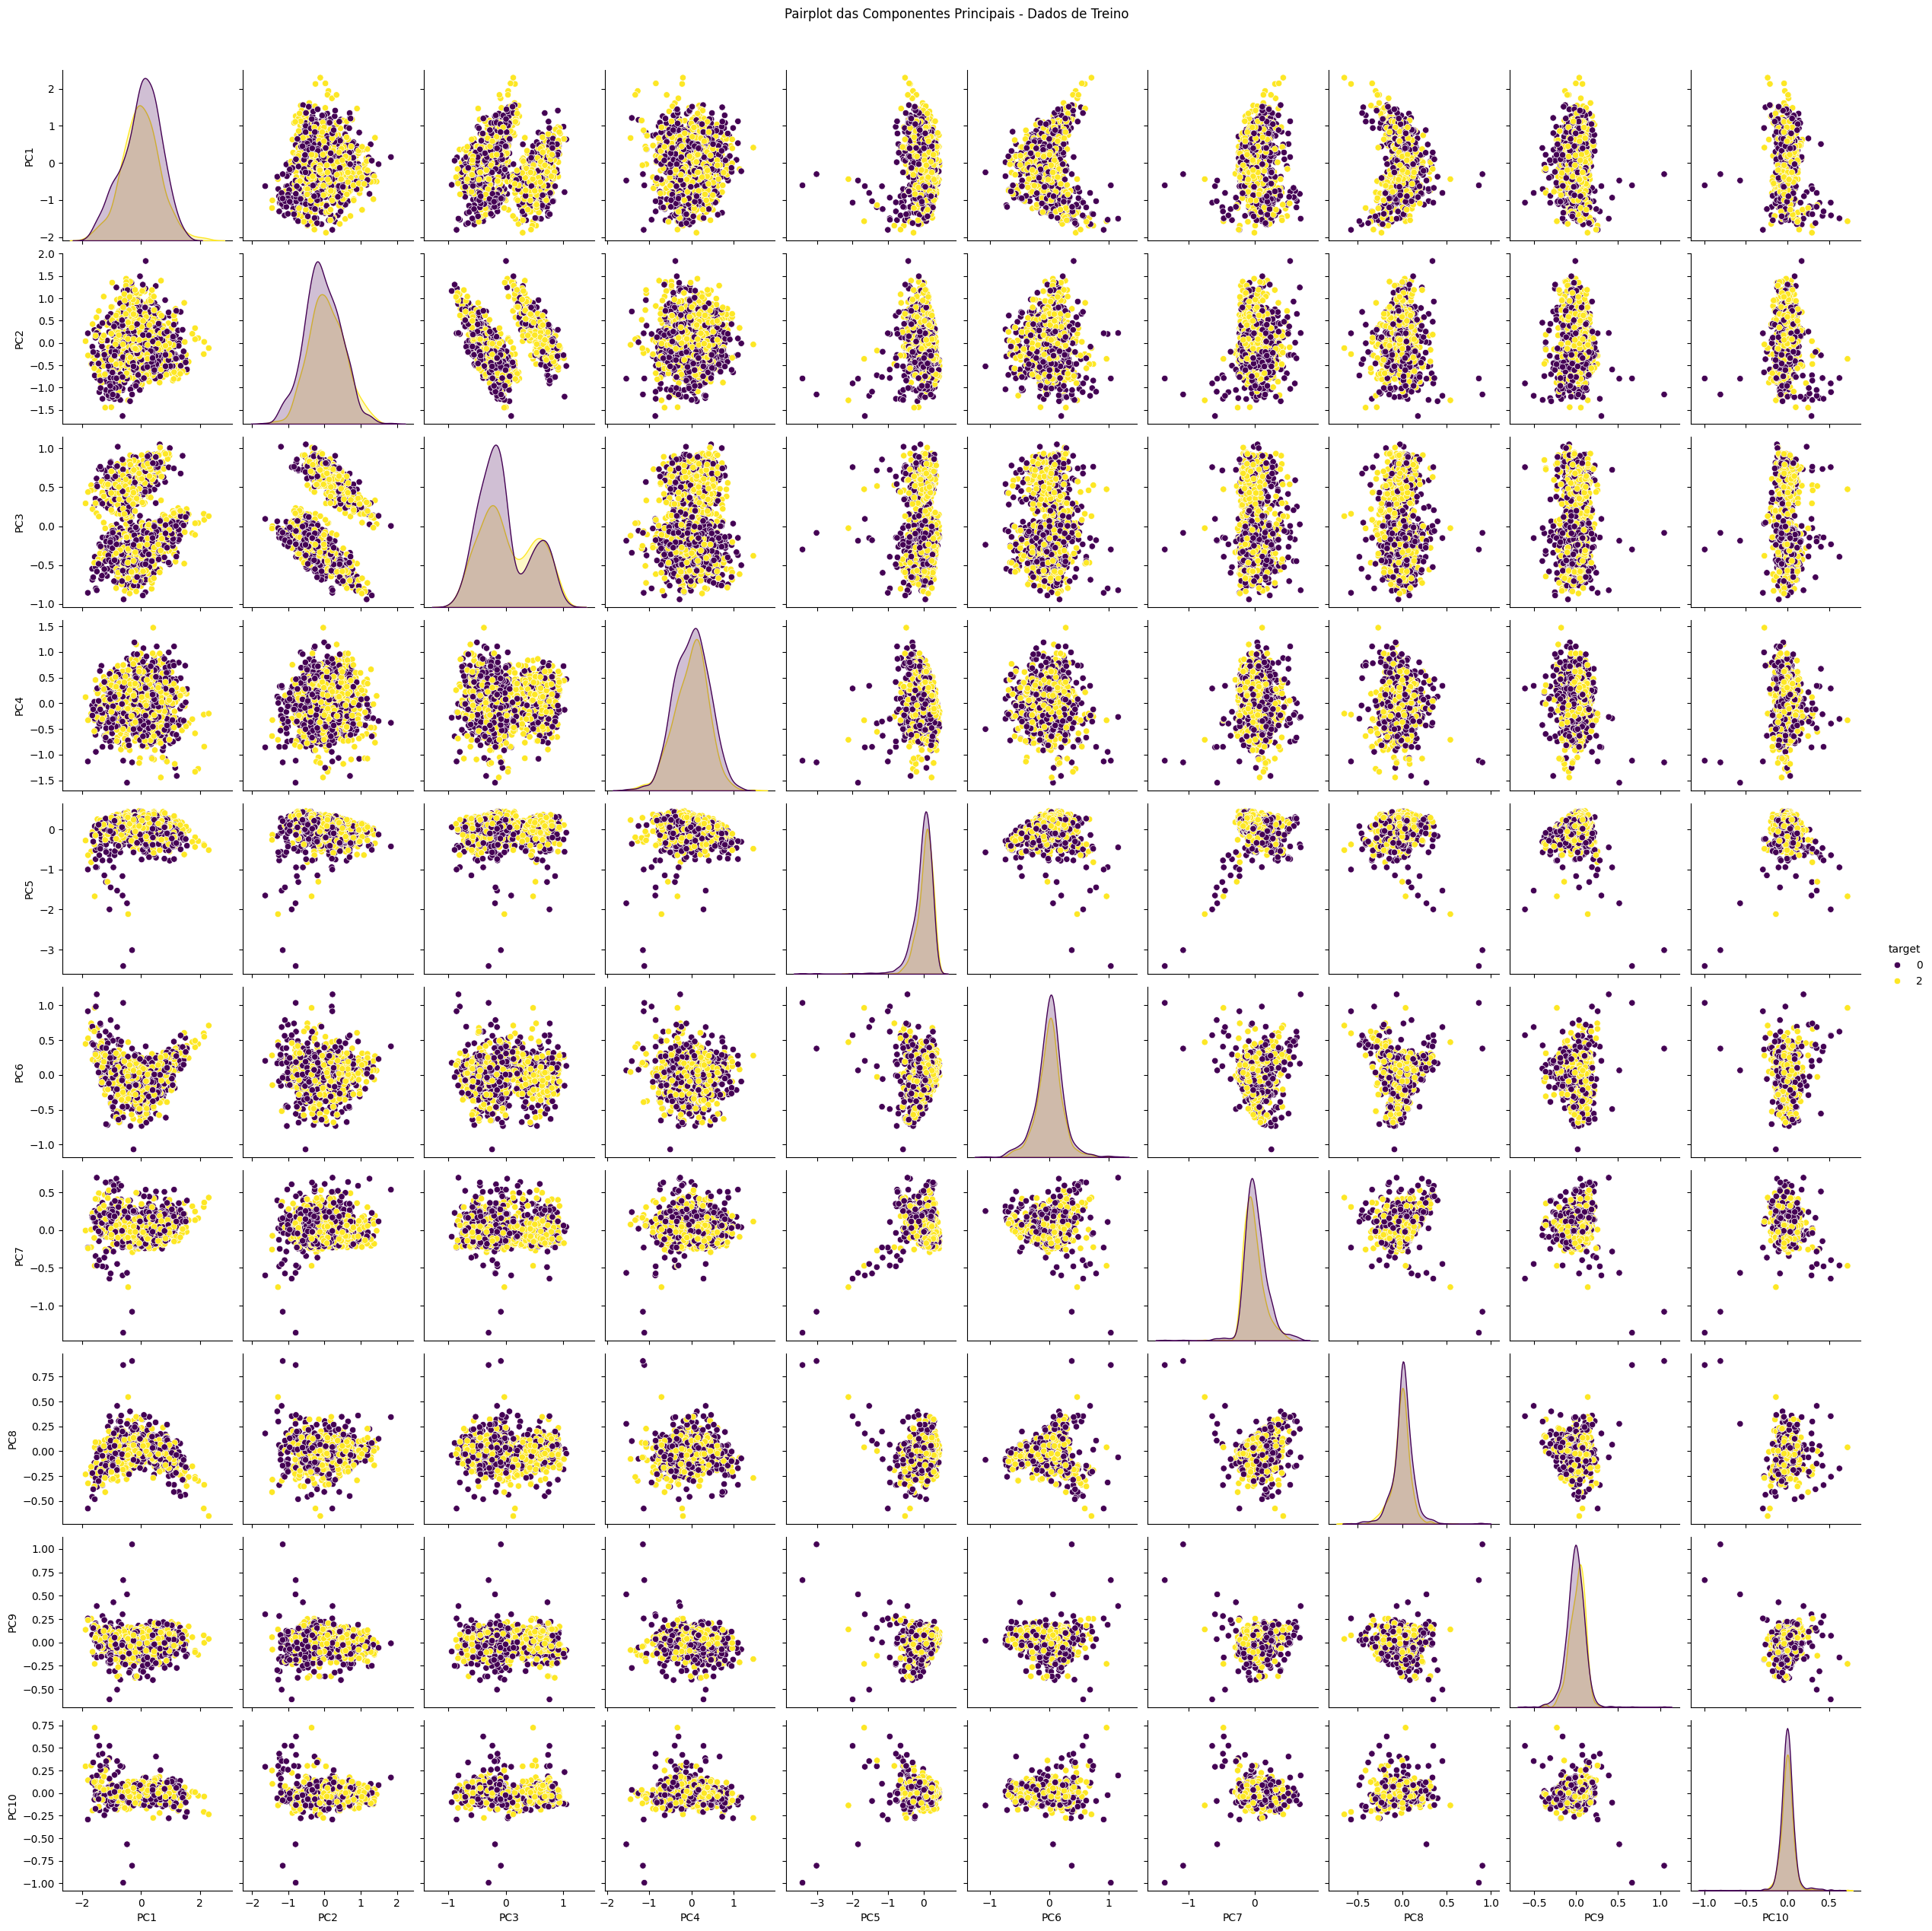

              precision    recall  f1-score   support

     Benigno       0.66      0.69      0.68       199
     Maligno       0.60      0.56      0.58       163

    accuracy                           0.64       362
   macro avg       0.63      0.63      0.63       362
weighted avg       0.63      0.64      0.63       362



In [ ]:
# Verifique o número de componentes que você pode usar
num_features = X_train.shape[1]
num_components = min(10, num_features)  # Garante que não exceda o número de características

# Inicializar PCA e transformar os dados de treino e teste
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Criar DataFrames para os dados transformados pelo PCA
df_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(num_components)])
df_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(num_components)])

# Adicionar a coluna de alvo (target) aos DataFrames
df_train_pca['target'] = y_train.reset_index(drop=True)  # Assegura que o índice coincide
df_test_pca['target'] = y_test.reset_index(drop=True)

# Imprimir a variância explicada por cada componente principal
print("Variância explicada por cada componente principal:", pca.explained_variance_ratio_)

# Criar um pairplot para visualizar todas as componentes principais
sns.pairplot(df_train_pca, hue='target', palette='viridis')
plt.suptitle('Pairplot das Componentes Principais - Dados de Treino', y=1.02)
plt.show()

# Inicializar e treinar o classificador LGBM
clf = LGBMClassifier(random_state=42, verbose=-1)
clf.fit(X_train_pca, y_train)

# Fazer previsões nos dados de teste
y_pred_LGBMClassifier_pca = clf.predict(X_test_pca)

# Imprimir o relatório de classificação
print(classification_report(y_test, y_pred_LGBMClassifier_pca, target_names=class_names))


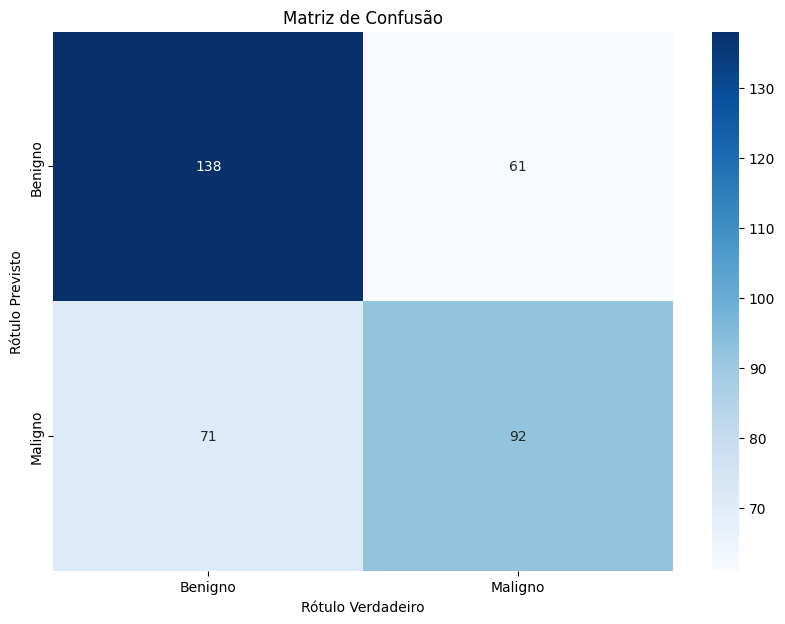

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plota a matriz de confusão.

    Parâmetros:
    y_true: array-like, verdadeiro rótulo das classes.
    y_pred: array-like, rótulo das classes previstas.
    class_names: lista de nomes das classes.
    """
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)

    # Plotar a matriz de confusão
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Rótulo Verdadeiro')
    plt.ylabel('Rótulo Previsto')
    plt.title('Matriz de Confusão')
    plt.show()

# Exemplo de uso da função
plot_confusion_matrix(y_test, y_pred_LGBMClassifier_pca)

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def calcular_pesos_classes(y):
    """
    Calcula os pesos das classes para balanceamento.

    Parâmetros:
    y (array-like): Array contendo as classes.

    Retorna:
    dict: Dicionário com os pesos das classes.
    """
    # Calcular pesos das classes
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )

    # Criar um dicionário com os pesos das classes
    class_weight_dict = dict(zip(np.unique(y), class_weights))

    return class_weight_dict

# Exemplo de uso da função
class_weight_dict = calcular_pesos_classes(y_train)
print("Pesos das classes:", class_weight_dict)

Pesos das classes: {0: 0.9084065244667503, 2: 1.1121351766513057}


#Múltiplos modelos

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.65      0.75      0.70       199
           2       0.63      0.51      0.56       163

    accuracy                           0.64       362
   macro avg       0.64      0.63      0.63       362
weighted avg       0.64      0.64      0.64       362





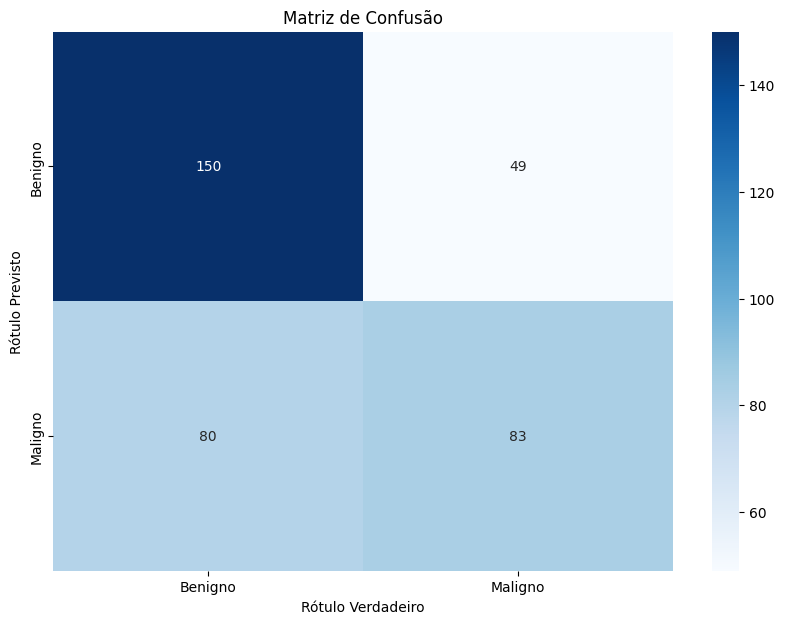

Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       199
           2       0.53      0.47      0.50       163

    accuracy                           0.57       362
   macro avg       0.57      0.57      0.56       362
weighted avg       0.57      0.57      0.57       362





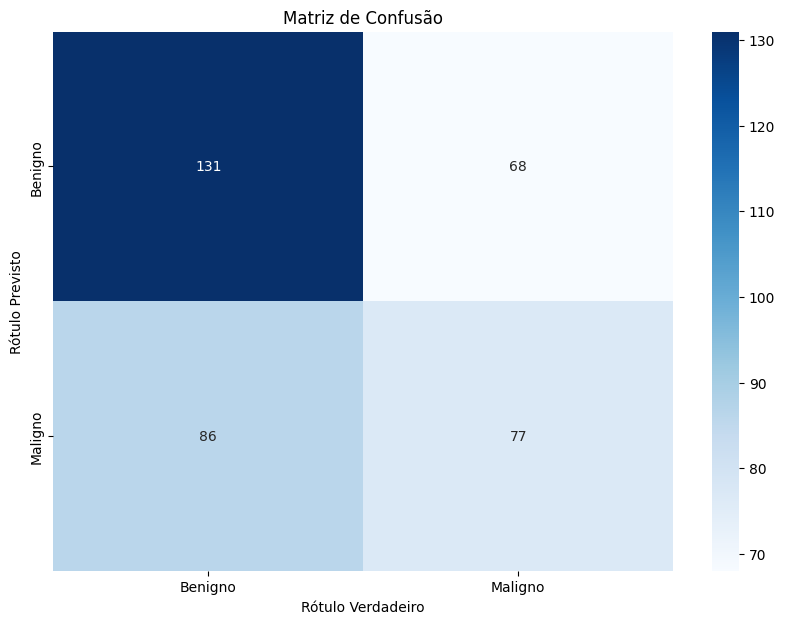

Classification Report for LightGBM:

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       199
           2       0.61      0.56      0.58       163

    accuracy                           0.64       362
   macro avg       0.64      0.63      0.63       362
weighted avg       0.64      0.64      0.64       362





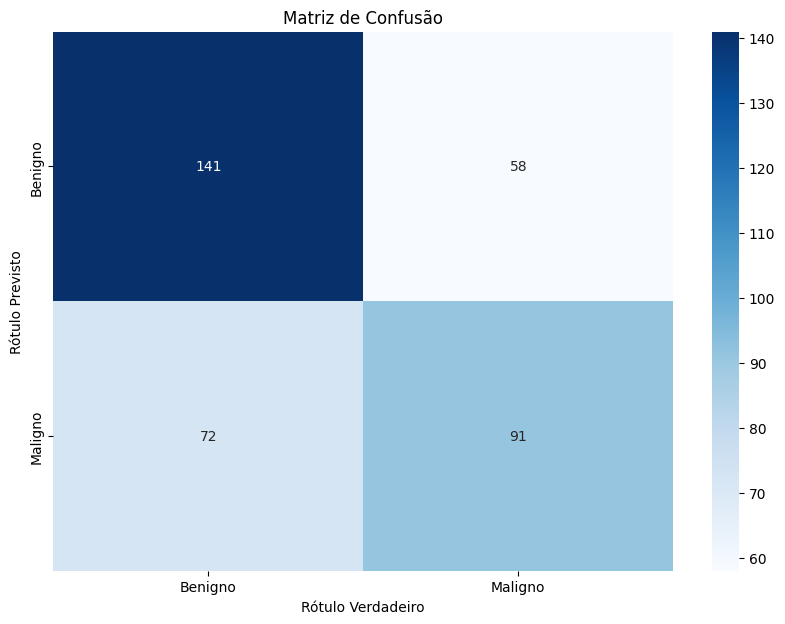

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       199
           2       0.58      0.47      0.52       163

    accuracy                           0.61       362
   macro avg       0.60      0.60      0.60       362
weighted avg       0.61      0.61      0.60       362





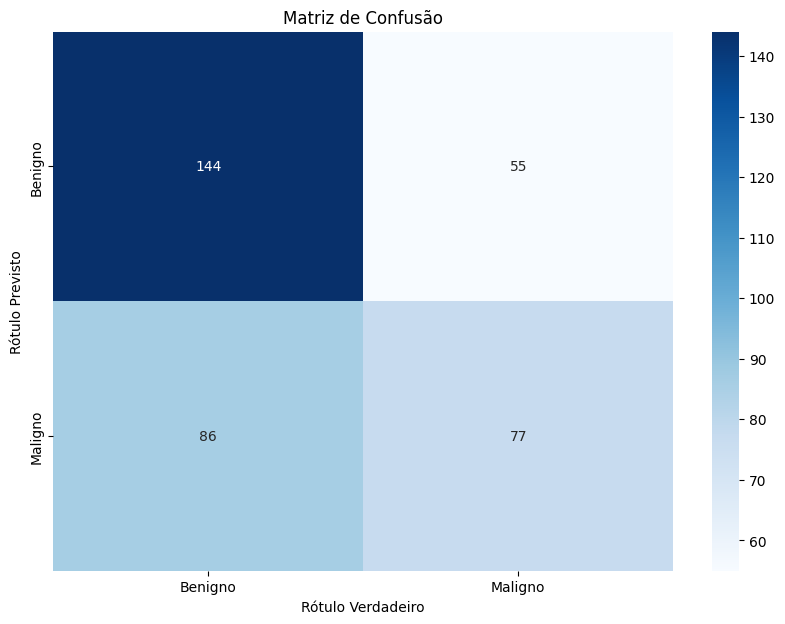

Classification Report for SVC:

              precision    recall  f1-score   support

           0       0.58      0.75      0.66       199
           2       0.53      0.35      0.42       163

    accuracy                           0.57       362
   macro avg       0.56      0.55      0.54       362
weighted avg       0.56      0.57      0.55       362





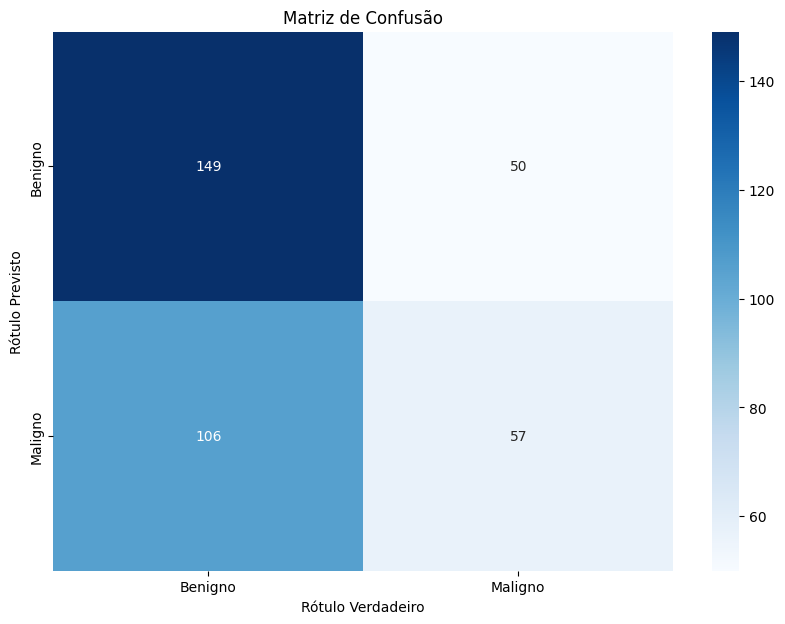

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       199
           2       0.43      0.43      0.43       163

    accuracy                           0.49       362
   macro avg       0.48      0.48      0.48       362
weighted avg       0.49      0.49      0.49       362





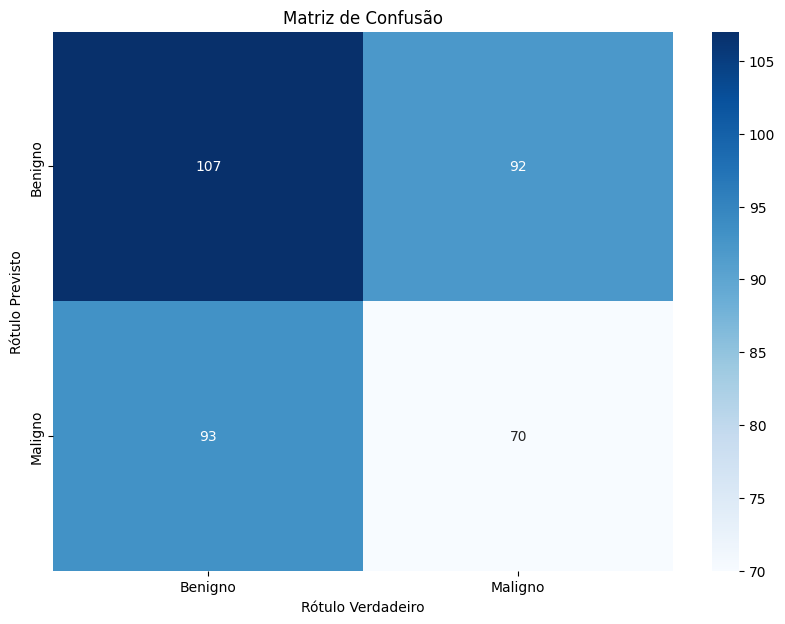

Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.63      0.72      0.67       199
           2       0.58      0.48      0.53       163

    accuracy                           0.61       362
   macro avg       0.60      0.60      0.60       362
weighted avg       0.61      0.61      0.60       362





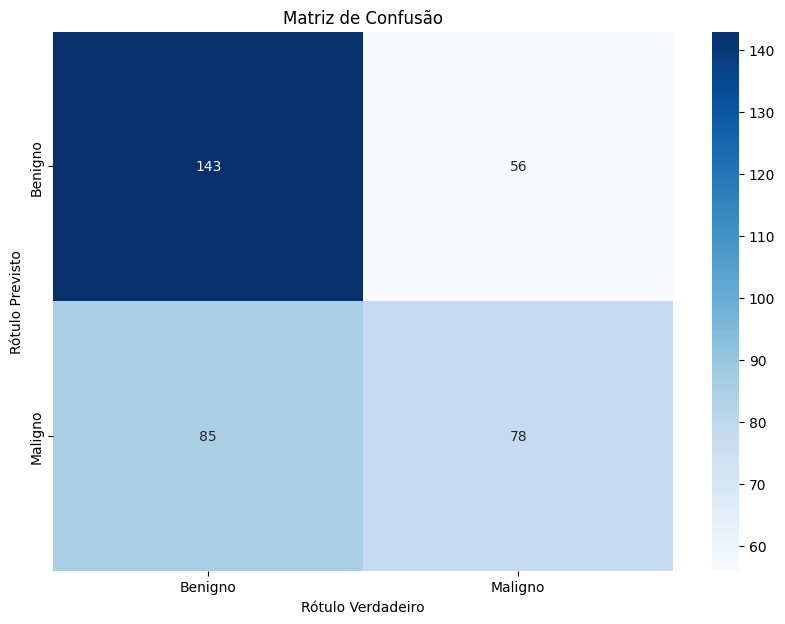

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       199
           2       0.58      0.55      0.56       163

    accuracy                           0.62       362
   macro avg       0.61      0.61      0.61       362
weighted avg       0.61      0.62      0.61       362





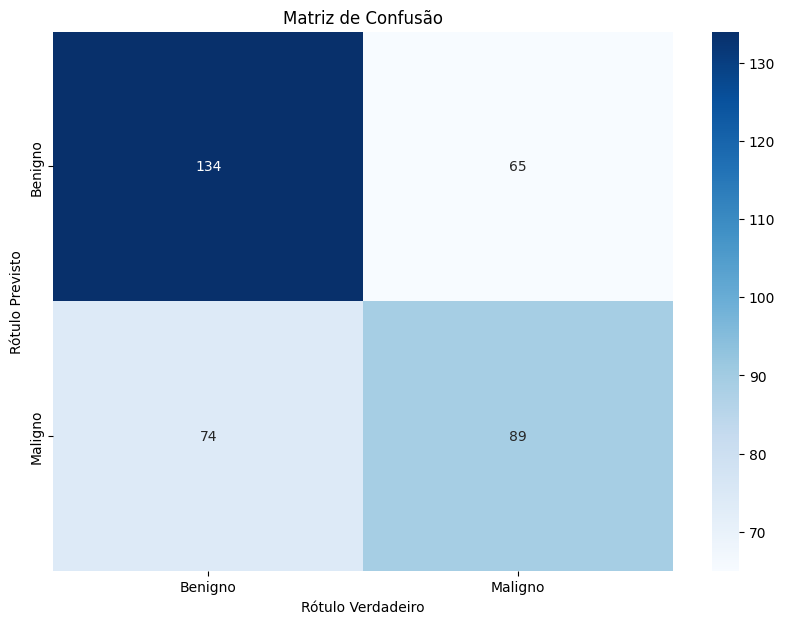

                     Accuracy
Random Forest        0.643646
LightGBM             0.640884
AdaBoost             0.616022
Logistic Regression  0.610497
Gradient Boosting    0.610497
KNN                  0.574586
SVC                  0.569061
Decision Tree        0.488950


In [ ]:


# Definir os modelos de classificação
models = {
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'LightGBM': LGBMClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# Inicializar o dicionário para armazenar os resultados
results = {}

# Iterar sobre cada modelo
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

    plot_confusion_matrix(y_test, y_pred)

# Criar um DataFrame a partir dos resultados e exibir os resultados ordenados por acurácia
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
print(results_df.sort_values(by='Accuracy', ascending=False))

#RFE

In [ ]:
from sklearn.feature_selection import RFE
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Cria uma instância do RFE (Recursive Feature Elimination) com um LGBMClassifier como estimador
# e seleciona as 5 melhores features
rfe = RFE(estimator=LGBMClassifier(random_state=42), n_features_to_select=10)

# Aplica o RFE aos dados de treino balanceados e transforma-os, selecionando as melhores features
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Aplica o RFE aos dados de teste normalizados, transformando-os com as mesmas features selecionadas no treino
X_test_rfe = rfe.transform(X_test)

# Define a grade de parâmetros para o GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10],           # Parâmetros C para o SVC
    'svc__kernel': ['linear', 'rbf'], # Tipos de kernel para o SVC
    'lgbm__n_estimators': [100, 150, 200],  # Número de árvores no LGBM
    'lgbm__max_depth': [10, 20, 30],        # Profundidade máxima das árvores no LGBM
    'lgbm__learning_rate': [0.01, 0.1, 0.2], # Taxa de aprendizado do LGBM
}

# Cria uma instância do SVC com probabilidade e um estado aleatório fixo para garantir a reprodutibilidade
svc = SVC(probability=True, random_state=42)

# Cria uma instância do LGBMClassifier com um estado aleatório fixo para garantir a reprodutibilidade
lgbm = LGBMClassifier(random_state=42)

# Cria uma instância do VotingClassifier com os estimadores SVC e LGBM
# O parâmetro voting='soft' usa as probabilidades preditas para a votação
voting_clf = VotingClassifier(estimators=[
    ('lgbm', lgbm),
    ('svc', svc)
], voting='soft')

# Cria uma instância do GridSearchCV para encontrar os melhores hiperparâmetros
# cv=5 significa que será usada validação cruzada com 5 folds
# n_jobs=-1 usa todos os processadores disponíveis
# verbose=2 exibe mensagens detalhadas durante o ajuste
# scoring='f1_weighted' usa a métrica F1 ponderada para avaliar os modelos
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=0, scoring='f1_weighted')

# Ajusta o GridSearchCV aos dados de treino balanceados e transformados pelo RFE
grid_search.fit(X_train_rfe, y_train)

# Obtém o melhor estimador encontrado pelo GridSearchCV
best_clf = grid_search.best_estimator_

# Faz previsões nos dados de teste transformados pelo RFE usando o melhor estimador
y_pred_grid_search = best_clf.predict(X_test_rfe)

# Imprime o relatório de classificação comparando as previsões com os valores reais das classes no conjunto de teste
print(classification_report(y_test, y_pred_grid_search, target_names=class_names))

# Imprime os melhores hiperparâmetros encontrados pelo GridSearchCV
print("Melhores hiperparâmetros encontrados:", grid_search.best_params_)

              precision    recall  f1-score   support

     Benigno       0.62      0.71      0.66       199
     Maligno       0.56      0.46      0.51       163

    accuracy                           0.60       362
   macro avg       0.59      0.58      0.58       362
weighted avg       0.59      0.60      0.59       362

Melhores hiperparâmetros encontrados: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 30, 'lgbm__n_estimators': 100, 'svc__C': 10, 'svc__kernel': 'rbf'}


In [ ]:

# Obtém um array booleano indicando quais features foram selecionadas pelo RFE
selected_features_indices = rfe.support_

# Obtém os nomes das features do conjunto de treino balanceado
feature_names = X_train.columns

# Seleciona os nomes das features que foram escolhidas pelo RFE
selected_features = feature_names[selected_features_indices]

# Cria um DataFrame com as features selecionadas
df_selected_features = pd.DataFrame(selected_features, columns=["Features selecionadas:"])
df_selected_features

Features selecionadas:
0                 original_firstorder_90Percentile
1                       original_firstorder_Energy
2                      original_firstorder_Entropy
3                     original_firstorder_Kurtosis
4                     original_firstorder_Skewness
5                               original_glcm_Idmn
6  original_gldm_DependenceNonUniformityNormalized
7                        original_ngtdm_Coarseness
8                          original_ngtdm_Contrast
9                          original_ngtdm_Strength

In [ ]:

# Obtém o ranking das features do RFE
feature_ranking = rfe.ranking_

# Cria uma lista de tuplas contendo os nomes das features e seus respectivos rankings
features_with_ranks = list(zip(feature_names, feature_ranking))

# Ordena a lista de features pelo ranking (em ordem crescente)
features_with_ranks_sorted = sorted(features_with_ranks, key=lambda x: x[1])

# Cria um DataFrame com as features e seus rankings
df_features_with_ranks = pd.DataFrame(features_with_ranks_sorted, columns=["Feature", "Rank"])

# Cria um DataFrame com as features e seus rankings
df_features_with_ranks = pd.DataFrame(features_with_ranks_sorted, columns=["Feature", "Rank"])

# Seleciona as 10 primeiras features
top_10_features = df_features_with_ranks.head(10)

# Salva as 10 primeiras features em um arquivo CSV
output_file_path = "/content/drive/MyDrive/features-radiomics/features_rfe.csv"
top_10_features.to_csv(output_file_path, index=False)

# Exibe o DataFrame das features ordenadas por ranking
df_features_with_ranks.head(10)

Feature  Rank
0                 original_firstorder_90Percentile     1
1                       original_firstorder_Energy     1
2                      original_firstorder_Entropy     1
3                     original_firstorder_Kurtosis     1
4                     original_firstorder_Skewness     1
5                               original_glcm_Idmn     1
6  original_gldm_DependenceNonUniformityNormalized     1
7                        original_ngtdm_Coarseness     1
8                          original_ngtdm_Contrast     1
9                          original_ngtdm_Strength     1

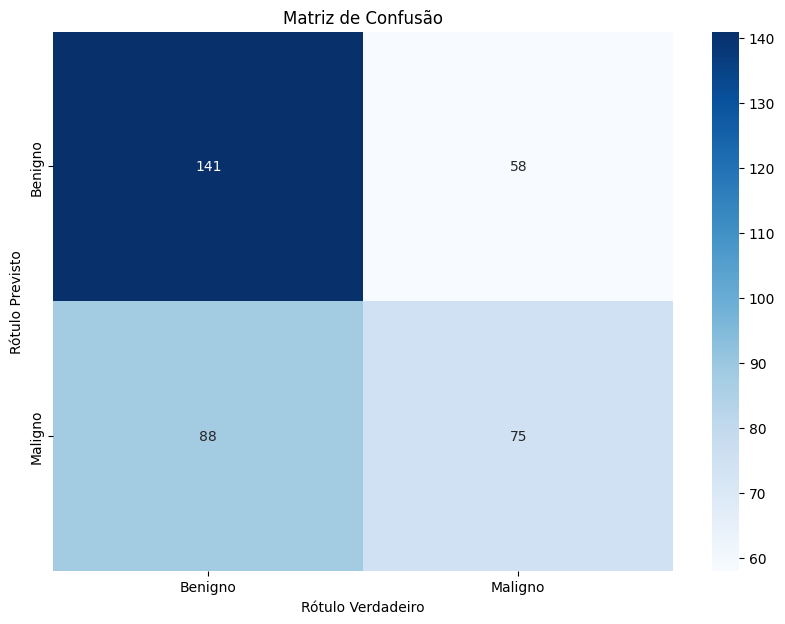

In [ ]:
# Exibir a matriz de confusão
plot_confusion_matrix(y_test, y_pred_grid_search)

#Tabnet

In [ ]:
# Definir o modelo TabNet
model = TabNetClassifier()

# Treinar o modelo
model.fit(X_train.values, y_train,
          eval_set=[(X_train.values, y_train), (X_test.values, y_test)],
          eval_name=['train', 'test'],
          eval_metric=['accuracy'],
          max_epochs=100, patience=10,
          batch_size=64, virtual_batch_size=64)

# Prever os resultados no conjunto de teste
y_pred_tabnet = model.predict(X_test.values)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred_tabnet)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

# Calcular e imprimir o relatório de classificação
report = classification_report(y_test, y_pred_tabnet, target_names=class_names)
print("Classification Report:\n", report)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81123 | train_accuracy: 0.46202 | test_accuracy: 0.44475 |  0:00:00s
epoch 1  | loss: 0.70054 | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:01s
epoch 2  | loss: 0.68861 | train_accuracy: 0.47445 | test_accuracy: 0.46133 |  0:00:02s
epoch 3  | loss: 0.68424 | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:03s
epoch 4  | loss: 0.68186 | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:03s
epoch 5  | loss: 0.68587 | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:04s
epoch 6  | loss: 0.6834  | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:05s
epoch 7  | loss: 0.67873 | train_accuracy: 0.55041 | test_accuracy: 0.5442  |  0:00:06s
epoch 8  | loss: 0.68246 | train_accuracy: 0.54765 | test_accuracy: 0.55525 |  0:00:07s
epoch 9  | loss: 0.68243 | train_accuracy: 0.5511  | test_accuracy: 0.55525 |  0:00:08s
epoch 10 | loss: 0.67693 | train_accuracy: 0.55041 | test_accuracy: 0.54972 |  0:00:09s
epoch 11 | loss: 0.67796 | train

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 62.43%
Classification Report:
               precision    recall  f1-score   support

     Benigno       0.61      0.85      0.71       199
     Maligno       0.66      0.34      0.45       163

    accuracy                           0.62       362
   macro avg       0.64      0.60      0.58       362
weighted avg       0.63      0.62      0.60       362



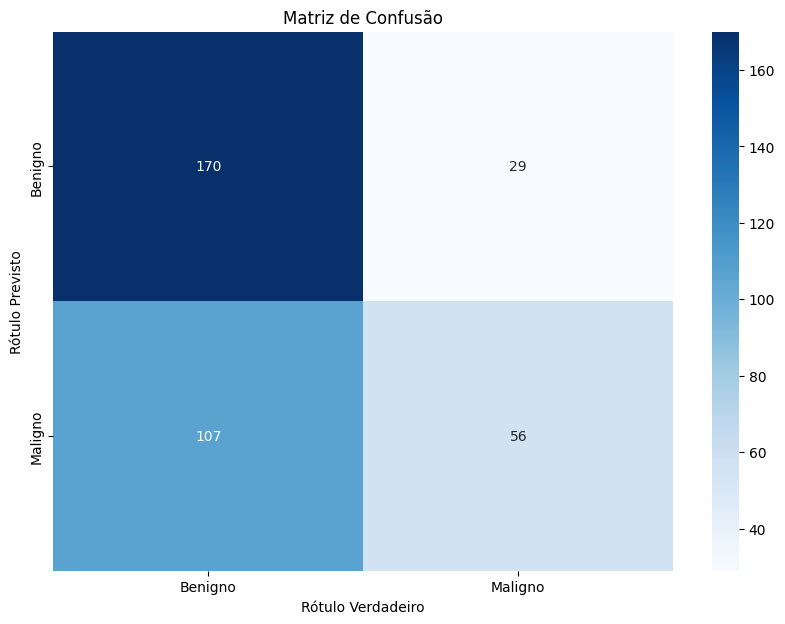

In [ ]:
plot_confusion_matrix(y_test, y_pred_tabnet)

In [ ]:
52373# Obtenha os nomes das features selecionadas
selected_features = df_selected_features["Features selecionadas:"].values

# Crie um novo DataFrame com a primeira e última coluna de df_base e as colunas selecionadas
def create_selected_dataframe(df_base, selected_features):
    # Verifique se df_base tem pelo menos duas colunas
    if df_base.shape[1] < 2:
        raise ValueError("O DataFrame deve ter pelo menos duas colunas.")

    # Selecione a primeira e a última coluna
    first_column = df_base.iloc[:, 0]  # Primeira coluna
    last_column = df_base.iloc[:, -1]   # Última coluna

    # Selecione as colunas intermediárias com base nas features selecionadas
    intermediate_columns = df_base[list(selected_features)]  # Seleciona as colunas pelo nome

    # Crie o novo DataFrame com as colunas selecionadas
    df_new = pd.concat([first_column, intermediate_columns, last_column], axis=1)

    return df_new

# Crie o novo DataFrame com as colunas selecionadas
df_selected = create_selected_dataframe(df, selected_features)

df_selected.to_csv('/content/drive/MyDrive/features-radiomics/features_filtradas_rfe.csv', index=False)

df_selected.head(5)

Transformed Image Names  original_firstorder_90Percentile  \
0    0_Calc-Test_P_00038_LEFT_CC_1_roi.png                           54244.0   
1   0_Calc-Test_P_00038_LEFT_MLO_1_roi.png                           50103.0   
2   0_Calc-Test_P_00100_RIGHT_CC_1_roi.png                           63758.0   
3  0_Calc-Test_P_00100_RIGHT_MLO_1_roi.png                           59912.0   
4    0_Calc-Test_P_00141_LEFT_CC_1_roi.png                           57498.0   

   original_firstorder_Energy  original_firstorder_Entropy  \
0                1.631849e+14                     8.461668   
1                9.166055e+13                     9.913416   
2                2.628008e+14                     9.221734   
3                1.894022e+14                     9.513728   
4                3.340389e+14                     9.388755   

   original_firstorder_Kurtosis  original_firstorder_Skewness  \
0                      2.729958                     -0.000881   
1                      2.091860                     -0.301841   
2                      3.545272                     -1.167521   
3                      2.534328                     -0.444005   
4                      2.920920                     -0.544722   

   original_glcm_Idmn  original_gldm_DependenceNonUniformityNormalized  \
0            0.995891                                         0.865470   
1            0.998762                                         0.868761   
2            0.999742                                         0.650751   
3            0.999432                                         0.778639   
4            0.999549                                         0.757573   

   original_ngtdm_Coarseness  original_ngtdm_Contrast  \
0                   0.000123                 5.416673   
1                   0.000299                14.347313   
2                   0.000951                 0.706177   
3                   0.000794                 1.171521   
4                   0.000372                 1.087884   

   original_ngtdm_Strength   class  
0                42.367873  BENIGN  
1               540.091956  BENIGN  
2               687.525538  BENIGN  
3               381.671430  BENIGN  
4               213.296874  BENIGN